In [145]:
# Makes it easier to debug
%load_ext autoreload
#%load_ext line_profiler
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pylab as plt
import numpy as np
import skimage.transform
import skimage.restoration
from tqdm import tqdm
import skimage.filters
import torch
import torch.nn as nn
import typing as tp
from pyrofit.utils import pad_dims
from torch.nn.functional import grid_sample
from pyro import distributions as dist
from pyrofit.lensing.utils import get_meshgrid
from pyrofit.lensing.lenses import SPLELens
from pyrofit.lensing.sources import SersicSource, AnalyticSource
from pyrofit.utils.torchutils import _mid_many, unravel_index
from pyrofit.utils import kNN
from fft_conv_pytorch import fft_conv, FFTConv2d
import swyft

## Basic idea

1) We learn $p(L|I)$ based on joined samples $L, I \sim p(L, I)$ vs marginal samples $L, I \sim p(L) p(I)$.  Here, we identify $z = L$ and $x = I$.
2) We learn $p(S|I, L)$, based on the identification of $x = (I, L)$ and $z=S$.

In [3]:
torch.cuda.set_device(0)
torch.set_default_tensor_type(torch.cuda.FloatTensor)
DEVICE='cuda'

In [4]:
NPIX = 50
CHANNELS = [0.5, 1, 2, 4, 8, 16, 32]
SIGMA = 0.02
KNN = 3

## General helper functions - should be part of swyft

In [5]:
def std_mean_weighted(x, w):
    m = (x*w).sum(axis=0)/w.sum(axis=0)
    r = x - m
    v = (r*r*w).sum(axis=0)/w.sum(axis=0)
    return m, v

In [6]:
# Estimate mean and variance of p(S|I)
def mean_std(s):
    #z_src_weighted = (s[..., 0] * s[..., 1]).sum(axis=0)/(s[..., 0]).sum(axis=0)
    m_src, v_src = std_mean_weighted(s[..., 1], s[..., 0])
    std_src = v_src**0.5
    return m_src, std_src

In [7]:
class RatioEstimatorGaussian1d(torch.nn.Module):
    def __init__(self, momentum = 0.1):
        super().__init__()
        self.momentum = momentum        
        self.x_mean = None
        self.z_mean = None
        self.x_var = None
        self.z_var = None
        self.xz_cov = None
        
    def forward(self, x: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        """2-dim Gaussian approximation to marginals and joint, assuming (B, N)."""
        if self.training:
            # Covariance estimates must be based on joined samples only
            # NOTE: This makes assumptions about the structure of mini batches during training (J, M, M, J, J, M, M, J, ...)
            # TODO: Change to (J, M, J, M, J, M, ...) in the future
            batch_size = len(x)
            idx = np.array([[i, i+3] for i in np.arange(0, batch_size, 4)]).flatten() 
            
            # Estimation w/o Bessel's correction, using simple MLE estimate (https://en.wikipedia.org/wiki/Estimation_of_covariance_matrices)
            x_mean_batch = x[idx].mean(dim=0).detach()
            z_mean_batch = z[idx].mean(dim=0).detach()
            x_var_batch = ((x[idx]-x_mean_batch)**2).mean(dim=0).detach()
            z_var_batch = ((z[idx]-z_mean_batch)**2).mean(dim=0).detach()
            xz_cov_batch = ((x[idx]-x_mean_batch)*(z[idx]-z_mean_batch)).mean(dim=0).detach()
            
            # Momentum-based update rule
            momentum = self.momentum
            self.x_mean = x_mean_batch if self.x_mean is None else (1-momentum)*self.x_mean + momentum*x_mean_batch
            self.x_var = x_var_batch if self.x_var is None else (1-momentum)*self.x_var + momentum*x_var_batch
            self.z_mean = z_mean_batch if self.z_mean is None else (1-momentum)*self.z_mean + momentum*z_mean_batch
            self.z_var = z_var_batch if self.z_var is None else (1-momentum)*self.z_var + momentum*z_var_batch
            self.xz_cov = xz_cov_batch if self.xz_cov is None else (1-momentum)*self.xz_cov + momentum*xz_cov_batch
            
        # log r(x, z) = log p(x, z)/p(x)/p(z), with covariance given by [[x_var, xz_cov], [xz_cov, z_var]]
        xb = (x-self.x_mean)/self.x_var**0.5
        zb = (z-self.z_mean)/self.z_var**0.5
        rho = self.xz_cov/self.x_var**0.5/self.z_var**0.5
        r = -0.5*torch.log(1-rho**2) + rho/(1-rho**2)*xb*zb - 0.5*rho**2/(1-rho**2)*(xb**2 + zb**2)
        out = torch.cat([r.unsqueeze(-1), z.unsqueeze(-1).detach()], dim=-1)
        return out

In [8]:
class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, **kwargs):
        self._data = kwargs
    
    def __len__(self):
        k = list(self._data.keys())[0]
        return len(self._data[k])
    
    def __getitem__(self, i):
        obs = {k: v[i] for k, v in self._data.items()}
        v = u = self._data['v'][i]
        return (obs, v, u)

In [9]:
#def simulate(model, dataset):
#    sim = []
#    for i in range(len(dataset)):
#        v = dataset[i]['v']
#        sim.append(model(v))

## Things that should be more general but are not right now

In [10]:
def simulate(d, src_samples):
    out = []
    Ntrain = len(d['z_lens'])
    for i in tqdm(range(Ntrain)):
        v = d['z_lens'][i]
        x = model(v, src_samples)
        out.append(x)
    out = torch.utils.data.dataloader.default_collate(out) # using torch internal functionality for this, yay!
    d.update(**out)
    for k, v in d.items():
        d[k] = v.cpu()
    return d

In [73]:
# Generate weighted p(S|I) samples, by evaluating p(S|I,L)/p(S) for samples from p(S)p(L|I)
def sample_source_weights(store, ratio, T = 1):
    dataset_constr = DictDataset(store)
    dataset_constr_src_as_param = DatasetAddSrcToParms(dataset_constr)

    dl = torch.utils.data.DataLoader(dataset_constr_src_as_param, batch_size = 128)
    out = []
    for d in dl:
        v = d[1]
        obs = d[0].copy()
        obs['img'] = obs0['img'].unsqueeze(0).expand(*obs['img'].shape)
        x = ratio.network.observation_transform(obs).cuda()
        z = ratio.network.parameter_transform(v).cuda()
        z_src = z[:,6:].view(-1, NPIX, NPIX).cpu()
        w = ratio.network.marginal_classifier(x, z).view(-1, NPIX, NPIX).detach().cpu()
        s = torch.stack([w, z_src], dim = -1)
        out.append(s)
    out = torch.cat(out)
    w = out[..., 0]
    w -= torch.max(w, dim=0).values
    w = torch.exp(w*T)
    out[..., 0] = w
    return out

In [12]:
def get_bounds(samples, th = 1e-6):
    lo = []
    hi = []
    for i in range(6):
        w = samples.weights[(i,)]
        s = samples.v[:,i][w > np.log(th)]
        lo.append(s.min())
        hi.append(s.max())
    low = np.array(lo)
    high = np.array(hi)
    return low, high

In [13]:
# Since we want to learn the src parameters, which are generated inside the generative model, 
# we simply attach the flattened src array to the parameter vectors and hope for the best

class DictDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self._dataset = dataset

    def __len__(self):
        return len(self._dataset[list(self._dataset.keys())[0]])
    
    def __getitem__(self, i):
        #src  = self._dataset['src'][i].cpu().flatten()
        v  = self._dataset['z_lens'][i]
        #v = torch.cat([v, src])
        x = {k: v[i] for k, v in self._dataset.items()}
        #x = noise(x, v)
        x['img'] = x['img'] + torch.randn_like(x['img'])*SIGMA
        return (x, v, v)

In [14]:
def get_z_lens_post_samples(posterior, N = 1000):
    samples_post = posterior.sample(N, obs0, batch_size = 1000)
    z_lens_post = np.array([samples_post[(i,)][:,0] for i in range(6)]).T
    return z_lens_post

In [15]:
def get_custom_marginal_classifier(
    observation_transform,
    marginal_indices: tuple,
    n_parameters: int,
    hidden_features: int,
    num_blocks: int,
    dropout = 0.,
    marginal_classifier = None,
    parameter_online_z_score: bool = True,
) -> torch.nn.Module:
    n_observation_features = observation_transform.n_features

    parameter_transform = swyft.networks.ParameterTransform(
        n_parameters, marginal_indices, online_z_score=parameter_online_z_score
    )
    n_marginals, n_block_parameters = parameter_transform.marginal_block_shape

    if marginal_classifier is None:
        marginal_classifier = swyft.networks.MarginalClassifier(
            n_marginals,
            n_observation_features + n_block_parameters,
            hidden_features=hidden_features,
            dropout_probability = dropout,
            num_blocks=num_blocks,
        )
    else:
        marginal_classifier = marginal_classifier(
            n_marginals,
            n_observation_features + n_block_parameters,
            hidden_features=hidden_features,
            dropout_probability = dropout,
            num_blocks=num_blocks,
        )

    return swyft.networks.Network(
        observation_transform,
        parameter_transform,
        marginal_classifier,
    )

## Things that should not be necessary

In [16]:
# Since we want to learn the src parameters, which are generated inside the generative model, 
# we simply attach the flattened src array to the parameter vectors and hope for the best

class DatasetAddSrcToParms(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self._dataset = dataset

    def __len__(self):
        return len(self._dataset)
    
    def __getitem__(self, i):
        src  = self._dataset[i][0]['src'].cpu().flatten()
        u  = self._dataset[i][1]
        v  = self._dataset[i][2]
        u = torch.cat([u, src])
        v = torch.cat([v, src])
        return (self._dataset[i][0], u, v)

In [17]:
class CustomParameterTransform(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
    def forward(self, v):
        # Don't do anything with the parameters!
        return v

## Physics model

### Generic physics model components

In [18]:
class RandomSource:
    def __init__(self, npix =  NPIX, channels = CHANNELS, K = 129):
        self._K = K
        self._channels = channels
        self._npix = npix
        
        self._kernels = self._get_kernels(self._K, self._channels)
        self._conv = self._get_kernel_conv(self._kernels)
        
    @staticmethod
    def _get_kernels(K, channels):
        C = len(channels)
        kernel = np.zeros((C, C, K, K))
        x = np.linspace(-64, 64, K)
        X, Y = np.meshgrid(x, x)
        R = (X**2 + Y**2)**0.5

        for i, s in enumerate(channels):
            kern = np.exp(-0.5*R**2/s**2)
            kern /= (kern**2).sum()**0.5
            kernel[i, i] = kern

        return kernel

    @staticmethod
    def _get_kernel_conv(kernel):
        C = len(kernel)
        K = len(kernel[0][0])
        gaussian_weights = nn.Parameter(torch.tensor(kernel).float().cuda())
        conv = FFTConv2d(in_channels = C, out_channels = C, kernel_size=K, bias=False, padding = int(K/2))
        with torch.no_grad():
            conv.weight = gaussian_weights
        return conv

    def _get_source_image(self, seeds, A=0.5, B = 0.3, C = 0.55, D = 4.):
        scales = A*(np.array(self._channels)/max(self._channels))**B
        seeds = seeds * torch.tensor(scales).cuda().float().unsqueeze(1).unsqueeze(2)
        x = torch.linspace(-1, 1, self._npix).to(seeds.device)
        X, Y = torch.meshgrid([x, x])
        R = (X**2 + Y**2)**0.5
        imgc = self._conv(seeds.unsqueeze(0)).squeeze(0).squeeze(0)
        img = imgc.sum(axis=-3)
        img = torch.exp(img)*(1/(1+(R/C)**D))
        return img

    def __call__(self):
        C = len(self._channels)
        return self._get_source_image(torch.randn(C, self._npix, self._npix).cuda()).detach()

In [19]:
class ArraySource(AnalyticSource):
    def __init__(self, image_array, x: float = 0., y: float = 0., scale: float = 1., peak_intensity: float = 1.,
                 origin: tp.Literal['lower', 'upper'] = 'lower', aspect=None, device=None):
        super().__init__(device=device)

        self.x, self.y = x, y
        self.peak_intensity = peak_intensity

        self.image = self._image(image_array, peak_intensity, device)

        if aspect is None:
            aspect = self.image.shape[-2] / self.image.shape[-1]
        self.semi_scale = torch.tensor([scale, (-1 if origin == 'lower' else 1) * aspect * scale], device=device) / 2

    def _image(self, image_array, peak_intensity=None, device=None) -> torch.Tensor:
        image = torch.tensor(image_array)
        if image.shape[-1] in (1, 3, 4):
            image = torch.movedim(image, -1, -3)
        if peak_intensity is not None:
            image = image.to(torch.get_default_dtype())
            image = image / torch.amax(image, (-2, -1), keepdim=True) * peak_intensity
        self.rollback_dims = image.ndim
        return pad_dims(image, ndim=4)[0].to(device=device, dtype=torch.get_default_dtype())

    def flux(self, X, Y):
        grid = torch.stack((X - self.x, Y - self.y), dim=-1).reshape(-1, *X.shape[-2:], 2) / self.semi_scale

        return grid_sample(
            self.image.expand(grid.shape[0], *self.image.shape[-3:]),
            grid,
            align_corners=True
        ).reshape(*X.shape[:-2], *self.image.shape[-self.rollback_dims:-2], *X.shape[-2:])

In [20]:
def get_kNN_idx(X, Y, Xsrc, Ysrc, k = 1):
        """Return indices into `Xsrc` and `Ysrc` closest to each point in `psrc`."""
        P = torch.stack((X, Y), -1).flatten(-3, -2)
        Psrc = torch.stack((Xsrc, Ysrc), -1).flatten(-3, -2)
        idx = unravel_index(kNN(P, Psrc, k).squeeze(-1), Xsrc.shape[-2:])
        idx = torch.reshape(idx, (NPIX, NPIX, k, 2))
        return idx

In [21]:
def deproject_idx(image, kNN_idx):
        """Return indices into `Xsrc` and `Ysrc` closest to each point in `psrc`."""
        k = kNN_idx.shape[-2]
        B = image.shape[0]
        #print(k, B)
        #print(image.shape)
        #print(kNN_idx.shape)
        # TODO: Need to speed up nested python loops
        src_image = torch.stack([torch.stack([image[b, kNN_idx[b, ..., i,0], kNN_idx[b, ..., i,1]] for i in range(k)]) for b in range(B)])
        return src_image

### SWYFT-specific wrappers

In [22]:
def image_generator(x, y, phi, q, r_ein, slope, src_image):
    res = 0.0125*8                      # resolution in arcsec
    nx, ny = 50, 50                   # number of pixels
    X, Y = get_meshgrid(res, nx, ny)    # grid

    # Lens
    lens = SPLELens(device=DEVICE)
    lens.XY = X,Y
    # Displacement field
    alphas = lens(x=x, y=y, phi=phi, q=q, r_ein=r_ein, slope=slope)

    # Lensing equation
    X_src = X - alphas[..., 0, :, :]
    Y_src = Y - alphas[..., 1, :, :]

    # Source
    source = ArraySource(src_image, peak_intensity = None, scale = 1)

    # Lensed source
    image = source(X=X_src, Y=Y_src)
    
    return image, [X, Y, X_src, Y_src]

In [23]:
def model(v, src_samples):
    x, y, phi, q, r_ein, slope = v[:6]
    slope = 2.0
    src_image = src_samples[np.random.randint(len(src_samples))].cuda()
    img, coords = image_generator(x, y, phi, q, r_ein, slope, src_image)
    X, Y, Xsrc, Ysrc = coords
    kNN_idx = get_kNN_idx(X/5, -Y/5, Xsrc, Ysrc, k = KNN)  # TODO: Need to sort out strange 1/5 and -1/5 factors
    return dict(img = img.cpu(), src = src_image.cpu(), kNN_idx = kNN_idx.cpu(), X = X.cpu(), Y = Y.cpu(), Xsrc = Xsrc.cpu(), Ysrc = Ysrc.cpu())

In [24]:
def noise(sim, v, sigma = SIGMA):
    sim['img'] = (sim['img'] + np.random.randn(50, 50)*sigma).float()
    return sim

## Problem-specific analysis components

### Inference networks

In [25]:
class CustomObservationTransformL(torch.nn.Module):
    def __init__(self, observation_key: str, observation_shapes: dict):
        super().__init__()
        self.observation_key = observation_key
        self.n_features = 16  # This attribute must be defined!
        
        self.online_z_score = swyft.networks.OnlineDictStandardizingLayer(observation_shapes)
        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(1, 10, 3),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(10, 20, 3),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(20, 40, 3),
            torch.nn.MaxPool2d(2),
            torch.nn.Flatten(),
            torch.nn.Linear(640, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 16),
        )

    def forward(self, obs: dict) -> torch.Tensor:
        obs = dict(img = obs['img'])
        x = self.online_z_score(obs)
        x = x[self.observation_key]
        x = x.unsqueeze(1)
        x = self.net(x).squeeze(1)
        return x

In [26]:
class CustomObservationTransform(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.n_features = None

    def forward(self, obs: dict) -> torch.Tensor:      
        img = obs['img'].view(-1, NPIX*NPIX)
        kNN_idx = obs['kNN_idx'].view(-1, NPIX*NPIX*2*KNN)
        #print(img.shape, kNN_idx.shape)
        #  Just pick image, forget the rest
        x = torch.cat([img, kNN_idx], dim=-1)
        return x
        
class CustomMarginalClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.n_features = None
        self.l = torch.nn.Linear(10, 10)
        self.reg1d = RatioEstimatorGaussian1d(momentum = 0.1)
        self.L = torch.nn.Linear(2500, 2500)
        
    def get_img_rec(self, x):
        x_img = x[:,:NPIX*NPIX].view(-1, NPIX, NPIX)
        x_kNN_idx = x[:,NPIX*NPIX:].view(-1, NPIX, NPIX, KNN, 2).long()
        x_img_rec = deproject_idx(x_img, x_kNN_idx)[:,:,:,:].mean(dim=1)
        x_img_rec = self.L(x_img_rec.view(-1, NPIX*NPIX)).view(-1, NPIX, NPIX)*0 + x_img_rec
        return x_img_rec
    
    def forward(self, x: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        # Don't cross the streams
        x_img_rec = self.get_img_rec(x)
        
        z_lens = z[:,:6]
        z_src = z[:,6:6+NPIX*NPIX].view(-1, NPIX, NPIX)
        
        # Until the end
        r = self.reg1d(x_img_rec, z_src)[..., 0].view(-1, NPIX*NPIX)
        return r

### Fitting routines

In [27]:
def fit_lens(Ntrain, obs0, lens_prior, src_samples, max_epochs = 100):
    torch.cuda.set_device(0)
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    DEVICE='cuda'
    z_lens = swyft.PriorTruncator(lens_prior, None).sample(Ntrain)
    z_lens = torch.tensor(z_lens).cpu()
    dict_store = dict(z_lens = z_lens)
    simulate(dict_store, src_samples)
    dataset = DictDataset(dict_store)
    torch.set_default_tensor_type(torch.FloatTensor)  # Needing this is kinda stupid
    marg_indices_l = tuple([(i,) for i in range(6)])
    network_1d_l = get_custom_marginal_classifier(
        observation_transform=CustomObservationTransformL('img', {'img': (50, 50)}),
        marginal_indices=marg_indices_l,
        n_parameters=6,
        dropout = 0.2,
        hidden_features=256,
        num_blocks=2)
    mre_1d_l = swyft.MarginalRatioEstimator(marginal_indices=marg_indices_l, network=network_1d_l, device=DEVICE)
    vl = mre_1d_l.train(dataset, batch_size = 64, max_epochs = max_epochs, early_stopping_patience = 25)
    posterior_1d_l = swyft.MarginalPosterior(mre_1d_l, lens_prior)
    samples_1d = posterior_1d_l.weighted_sample(100000, obs0, batch_size = 1000)
    return dict(vl = vl, samples = samples_1d, prior = lens_prior, posterior = posterior_1d_l, store = dict_store)

In [74]:
def estimate_source(posterior, N = 100):
    # Generate samples from p(L|I)
    z_lens_post = get_z_lens_post_samples(posterior, N = N)
    store_LI = dict(z_lens = torch.tensor(z_lens_post).float().cpu())
    
    # Simulate draws from the p(S)p(L|I) and associated displacement fields
    torch.cuda.set_device(0)
    torch.set_default_tensor_type(torch.cuda.FloatTensor)  
    dict_store_src2 = simulate(store_LI, src_samples)
    
    # Training p(S|I,L)/p(S) ratios, based on examples from p(I|S,L)p(S)p_c(L)
    torch.set_default_tensor_type(torch.FloatTensor)  # Needing this is kinda stupid
    dataset = DictDataset(dict_store_src2)
    dataset_src_as_param = DatasetAddSrcToParms(dataset)
    observation_transform = CustomObservationTransform()
    parameter_transform = CustomParameterTransform()
    marginal_classifier = CustomMarginalClassifier()
    network_1d = swyft.networks.Network(observation_transform, parameter_transform, marginal_classifier).cuda()
    DEVICE = 'cuda'
    ratio_S_IL = swyft.MarginalRatioEstimator(marginal_indices=[(1,)], network=network_1d, device=DEVICE)
    ratio_S_IL.train(dataset_src_as_param, batch_size = 32, max_epochs = 5, learning_rate = 1e-2, optimizer = torch.optim.Adam)
    
    weighted_samples_S = sample_source_weights(dict_store_src2, ratio_S_IL)
    m_src, std_src = mean_std(weighted_samples_S)
    return dict(m=m_src, s=std_src, w=weighted_samples_S)

### Initial and constrained priors

In [28]:
def get_prior(low = None, high = None):
    if low is None:
        low =  np.array([-0.2, -0.2, 0, 0.2, 1.0, 1.5])
    if high is None:
        high = np.array([0.2, 0.2, 1.5, 0.9, 2.0, 2.5])
    prior = swyft.get_uniform_prior(low, high)
    return prior

In [29]:
# Initial prior
def get_source_samples(N = 1000):
    rnd_src = RandomSource()
    return [rnd_src().cuda() for i in range(N)]

In [30]:
# Samples from p_c(S|I)
def sample_constr_src(m_src, std_src):
    rnd_src = RandomSource()
    rnd = rnd_src().cpu() - rnd_src().cpu()
    rnd /= rnd.std()
    sample = m_src*np.exp(std_src*rnd*0.3)
    return sample

## Target image

<ipython-input-19-6c7c12c26adf>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image_array)


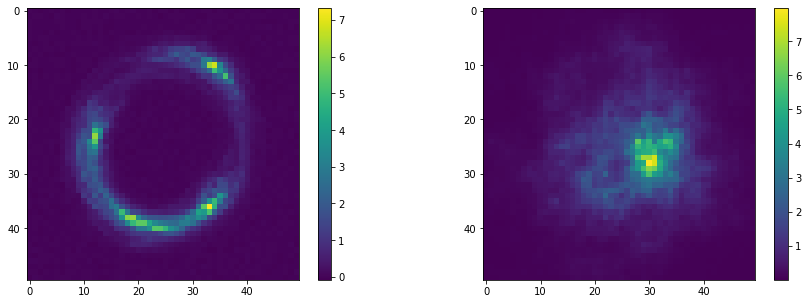

In [134]:
torch.cuda.set_device(0)
torch.set_default_tensor_type(torch.cuda.FloatTensor)    
v0 = np.array([0., 0.1, 0.5, 0.6, 1.5, 2.0])
src_samples = get_source_samples(N = 1)
#src_samples[0][23:27] = 0
#src_samples[0][30:34] = 0
#src_samples[0][15:19] = 0
obs0 = model(v0, src_samples)
obs0 = noise(obs0, v0)
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(obs0['img'])
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(obs0['src'])
plt.colorbar()

# Workflow

In [135]:
SMOKE_TEST = False

In [136]:
if SMOKE_TEST:
    Ntrain1, ME1, R1, Nsrc = 1000, 10, 1, 100
else:
    Ntrain1, ME1, R1, Nsrc = 10000, 100, 3, 1000

In [137]:
lens_prior_init = get_prior()
src_samples = get_source_samples(N = Ntrain1)
lens_fit_results = []
lens_prior_trunc = None

### Lens parameter fits 1

In [ ]:
for _ in range(R1):
    lens_prior_trunc = lens_prior_trunc if lens_prior_trunc else lens_prior_init
    fit_result = fit_lens(Ntrain1, obs0, lens_prior_trunc, src_samples, max_epochs = ME1)
    low, high = get_bounds(fit_result['samples'])
    lens_prior_trunc = get_prior(low = low, high = high)
    print("Constrained prior volume:", (high-low).prod())
    lens_fit_results.append(fit_result)

  0%|          | 0/10000 [00:00<?, ?it/s]<ipython-input-19-6c7c12c26adf>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image_array)
  0%|          | 15/10000 [00:00<05:55, 28.12it/s]

In [ ]:
plt.plot([v.item() for v in lens_fit_results[-1]['vl']])

In [ ]:
f = lens_fit_results[-1]
#dataset = DictDataset(f['store'])
#obs, v, v, = dataset[-6]
obs, v = obs0, v0
s = f['posterior'].weighted_sample(10000, obs, batch_size = 1000)
fig = swyft.hist1d(s, kde = False, figsize = (20, 5), truth = v);

### Source parameter fits 1

In [ ]:
out = estimate_source(lens_fit_results[-1]['posterior'], N = Nsrc)

In [ ]:
z_src = obs0['src']
m_src = out['m']
std_src = out['s']
img = m_src
vmax = torch.max(torch.abs(img))
plt.imshow(img)#, cmap = 'coolwarm', vmin = -vmax, vmax = vmax)
plt.colorbar()

In [ ]:
src_samples = torch.stack([sample_constr_src(m_src, std_src) for _ in range(1000)])

plt.figure(figsize = (15, 15))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(src_samples[i])

### Lens parameter fits 2

In [ ]:
for _ in range(R1):
    fit_result = fit_lens(Ntrain1, obs0, lens_prior_trunc, src_samples, max_epochs = ME1)
    low, high = get_bounds(fit_result['samples'])
    lens_prior_trunc = get_prior(low = low, high = high)
    print("Constrained prior volume:", (high-low).prod())
    lens_fit_results.append(fit_result)

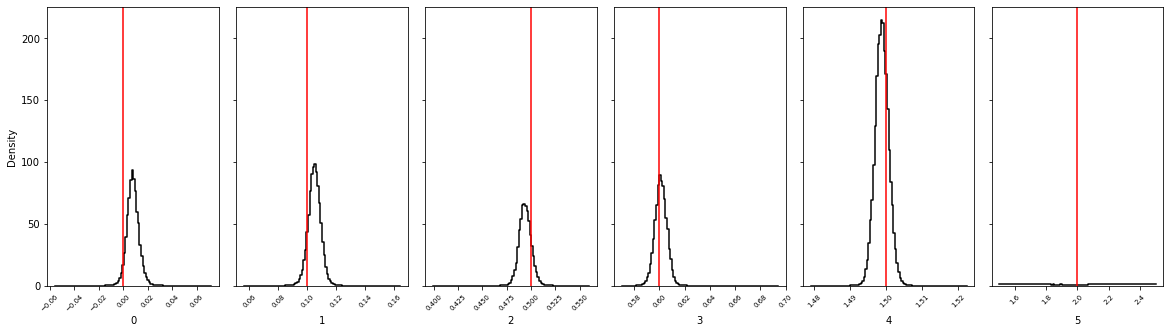

In [148]:
fig = swyft.hist1d(lens_fit_results[-1]['samples'], kde = False, figsize = (20, 5), truth = v0);
# x, y, phi, q, r_ein, slope

### Source parameter fits 2

In [ ]:
out = estimate_source(lens_fit_results[-1]['posterior'], N = Nsrc)

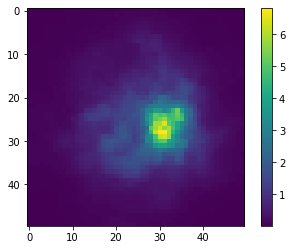

In [147]:
z_src = obs0['src']
m_src = out['m']
std_src = out['s']
img = m_src
vmax = torch.max(torch.abs(img))
plt.imshow(img)#, cmap = 'coolwarm', vmin = -vmax, vmax = vmax)
plt.colorbar()

In [ ]:
src_samples = torch.stack([sample_constr_src(m_src, std_src) for _ in range(1000)])

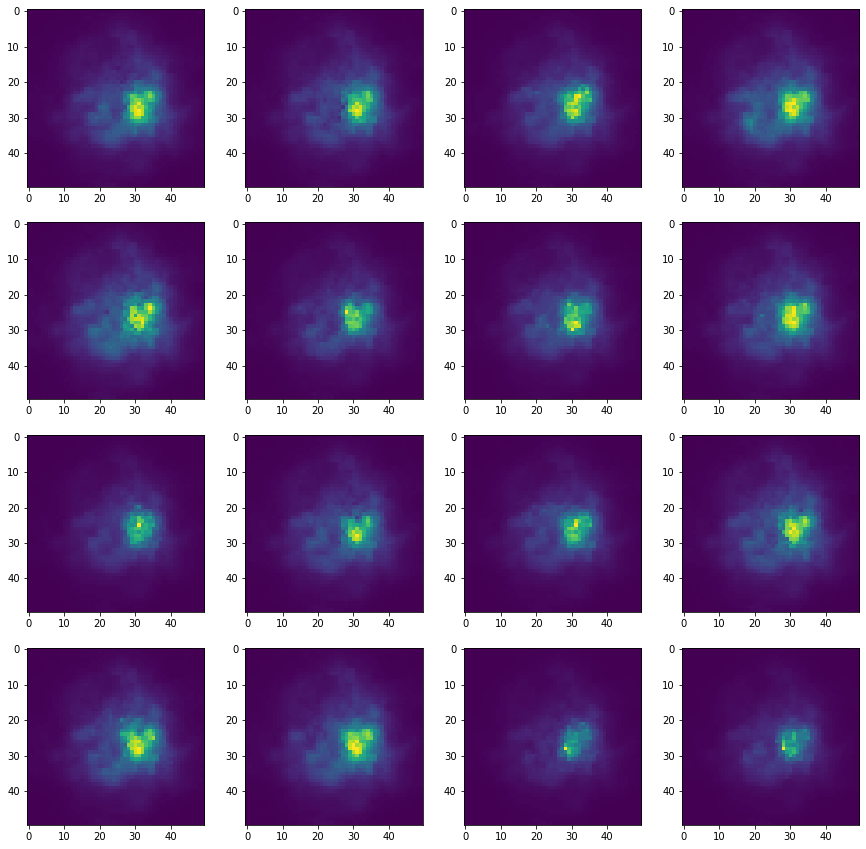

In [146]:
plt.figure(figsize = (15, 15))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(src_samples[i])